<a href="https://colab.research.google.com/github/alecbidaran/Pytorch_excersies/blob/main/pytorch_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch_snippets
from torch_snippets import *

     |████████████████████████████████| 61kB 5.8MB/s 
     |████████████████████████████████| 215kB 23.4MB/s 
     |████████████████████████████████| 61kB 7.2MB/s 
     |████████████████████████████████| 51kB 6.0MB/s 


2021-06-14 06:48:55.915 | WARNING  | torch_snippets.torch_loader:<module>:233 - Not importing Lightning Report
2021-06-14 06:48:56.620 | WARNING  | torch_snippets:<module>:13 - sklearn is not found. Skipping relevant imports from submodule `sklegos`
Exception: No module named 'sklego'


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from torchvision import transforms,datasets
import torch.nn.functional as F

In [ ]:
transform_image=transforms.Compose([transforms.ToTensor()])

In [ ]:
train_data=datasets.MNIST(root="./data",train=True,download=True,transform=transform_image)
test_data=datasets.MNIST(root="./data",train=False,download=True,transform=transform_image)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


In [ ]:
class ConAE(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=torch.nn.Sequential(
        torch.nn.Conv2d(1,32,3,stride=2,padding=1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride=2),
        torch.nn.Conv2d(32,64,3,stride=2,padding=1),
        torch.nn.ReLU(True),
        torch.nn.MaxPool2d(2,stride=2) )
    self.decoder=torch.nn.Sequential(
        torch.nn.ConvTranspose2d(64,32,3,stride=2),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(32,16,5,stride=3,padding=1),
        torch.nn.ReLU(True),
        torch.nn.ConvTranspose2d(16,1,2,stride=2,padding=1),
        torch.nn.Tanh()
    )
  def forward(self,x):
    x=self.encoder(x)
    out=self.decoder(x)
    return out 

In [ ]:
model=ConAE().to("cuda")

In [ ]:
!pip install torch_summary
from torchsummary import summary


In [ ]:
summary(model, torch.zeros(2,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 14, 14]          320
|    └─ReLU: 2-2                         [-1, 32, 14, 14]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 7, 7]            --
|    └─Conv2d: 2-4                       [-1, 64, 4, 4]            18,496
|    └─ReLU: 2-5                         [-1, 64, 4, 4]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [ ]:
loss_fn=torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
def train_step(input):
  model.train()
  z=model(input)
  optimizer.zero_grad()
  loss=loss_fn(z,input)
  loss.backward()
  optimizer.step()
  return loss
@torch.no_grad()
def validation_step(input):
  model.eval()
  z=model(input)
  optimizer.zero_grad()
  loss=loss_fn(z,input)
  return loss


num_epoch=5
log=Report(num_epoch)

In [ ]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
valid_loader=DataLoader(test_data,batch_size=64,shuffle=False)

In [ ]:
for epoch in range(num_epoch):
    N = len(train_loader)
    for ix, (data, _) in enumerate(train_loader):
        loss = train_step(data.to("cuda"))
        log.record(pos=(epoch + (ix+1)/N), trn_loss=loss, end='\r')
        
    N = len(valid_loader)
    for ix, (data, _) in enumerate(valid_loader):
        loss = validation_step(data.to("cuda"))
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
        
    log.report_avgs(epoch+1)

EPOCH: 1.000	trn_loss: 0.132	val_loss: 0.065	(12.56s - 50.22s remaining)
EPOCH: 2.000	trn_loss: 0.058	val_loss: 0.053	(24.59s - 36.88s remaining)
EPOCH: 3.000	trn_loss: 0.049	val_loss: 0.047	(36.48s - 24.32s remaining)
EPOCH: 4.000	trn_loss: 0.044	val_loss: 0.043	(48.74s - 12.18s remaining)
EPOCH: 5.000	trn_loss: 0.042	val_loss: 0.041	(60.71s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 600.53it/s]


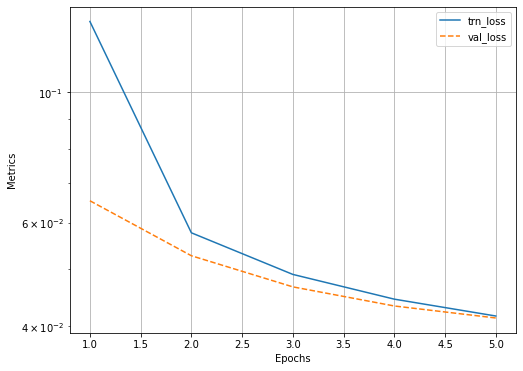

In [ ]:
log.plot_epochs(log=True)

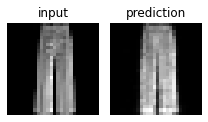

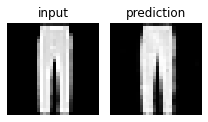

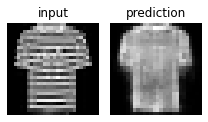

In [ ]:
for _ in range(3):
    ix = np.random.randint(len(test_data))
    im, _ = test_data[ix]
    _im = model(im[None].cuda())[0]
    fig, ax = plt.subplots(1, 2, figsize=(3,3))
    show(im[0], ax=ax[0], title='input')
    show(_im[0], ax=ax[1], title='prediction')
    plt.tight_layout()
    plt.show()

# VAE

In [ ]:
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim1, h_dim2, z_dim):
        super(VAE, self).__init__()
        self.cnn1=torch.nn.Conv2d(1,32,3,stride=2,padding=1)
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
    def encoder(self, x):
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        return F.sigmoid(self.d6(h))
    def forward(self, x):
        mean, log_var = self.encoder(x.view(-1, 784))
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [ ]:
!pip install torchinfo
import torchinfo

In [ ]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to(device)
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [ ]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

In [ ]:
vae = VAE(x_dim=784, h_dim1=512, h_dim2=256, z_dim=50).to("cuda")
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

In [ ]:
summary(vae,torch.zeros((2,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 401,920
├─Linear: 1-2                            [-1, 256]                 131,328
├─Linear: 1-3                            [-1, 50]                  12,850
├─Linear: 1-4                            [-1, 50]                  12,850
├─Linear: 1-5                            [-1, 256]                 13,056
├─Linear: 1-6                            [-1, 512]                 131,584
├─Linear: 1-7                            [-1, 784]                 402,192
Total params: 1,105,780
Trainable params: 1,105,780
Non-trainable params: 0
Total mult-adds (M): 1.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.22
Estimated Total Size (MB): 4.24


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 512]                 401,920
├─Linear: 1-2                            [-1, 256]                 131,328
├─Linear: 1-3                            [-1, 50]                  12,850
├─Linear: 1-4                            [-1, 50]                  12,850
├─Linear: 1-5                            [-1, 256]                 13,056
├─Linear: 1-6                            [-1, 512]                 131,584
├─Linear: 1-7                            [-1, 784]                 402,192
Total params: 1,105,780
Trainable params: 1,105,780
Non-trainable params: 0
Total mult-adds (M): 1.10
Input size (MB): 0.01
Forward/backward pass size (MB): 0.02
Params size (MB): 4.22
Estimated Total Size (MB): 4.24

In [ ]:
from torchvision.utils import make_grid

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


EPOCH: 1.000	train_loss: 2450.765	train_kld: 376.068	train_recon: 2074.696	train_log_var: -0.231	train_mean: 0.002	val_loss: 2234.101	val_kld: 435.265	val_recon: 1798.836	val_log_var: -0.277	val_mean: -0.002	(13.79s - 124.11s remaining)


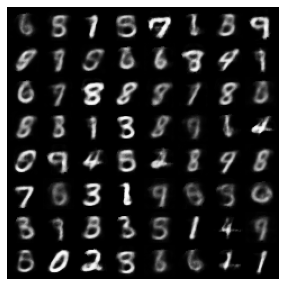

EPOCH: 2.000	train_loss: 2177.997	train_kld: 457.399	train_recon: 1720.598	train_log_var: -0.283	train_mean: 0.001	val_loss: 2105.302	val_kld: 480.933	val_recon: 1624.369	val_log_var: -0.298	val_mean: -0.002	(27.78s - 111.13s remaining)


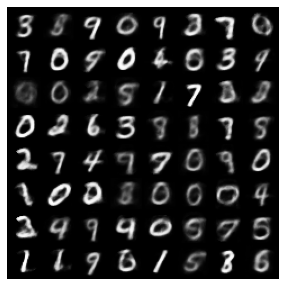

EPOCH: 3.000	train_loss: 2085.683	train_kld: 496.469	train_recon: 1589.214	train_log_var: -0.308	train_mean: 0.001	val_loss: 2028.548	val_kld: 504.719	val_recon: 1523.828	val_log_var: -0.315	val_mean: 0.000	(42.34s - 98.78s remaining)


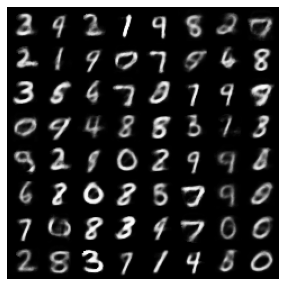

EPOCH: 4.000	train_loss: 2029.273	train_kld: 516.145	train_recon: 1513.128	train_log_var: -0.321	train_mean: 0.000	val_loss: 1993.677	val_kld: 530.355	val_recon: 1463.322	val_log_var: -0.330	val_mean: -0.002	(56.41s - 84.62s remaining)


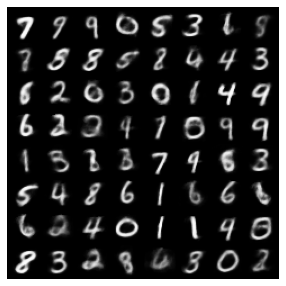

EPOCH: 5.000	train_loss: 1990.408	train_kld: 535.998	train_recon: 1454.410	train_log_var: -0.334	train_mean: 0.000	val_loss: 1954.278	val_kld: 549.702	val_recon: 1404.576	val_log_var: -0.337	val_mean: -0.001	(71.08s - 71.08s remaining)


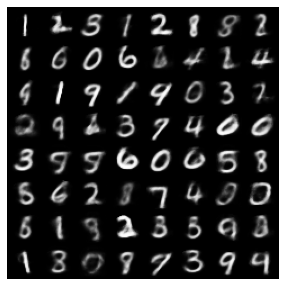

EPOCH: 6.000	train_loss: 1951.382	train_kld: 555.342	train_recon: 1396.039	train_log_var: -0.345	train_mean: 0.000	val_loss: 1929.759	val_kld: 557.356	val_recon: 1372.403	val_log_var: -0.343	val_mean: -0.008	(85.34s - 56.89s remaining)


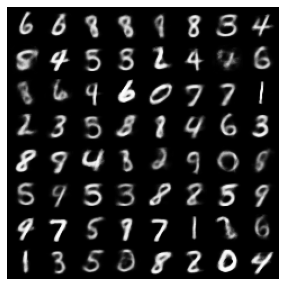

EPOCH: 7.000	train_loss: 1927.016	train_kld: 571.272	train_recon: 1355.745	train_log_var: -0.356	train_mean: 0.000	val_loss: 1900.754	val_kld: 571.864	val_recon: 1328.890	val_log_var: -0.359	val_mean: 0.000	(99.68s - 42.72s remaining)


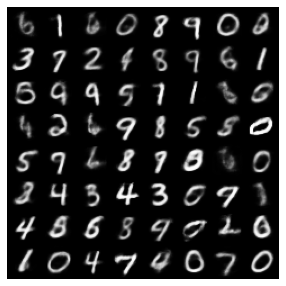

EPOCH: 8.000	train_loss: 1907.475	train_kld: 581.856	train_recon: 1325.620	train_log_var: -0.362	train_mean: 0.000	val_loss: 1893.678	val_kld: 577.691	val_recon: 1315.987	val_log_var: -0.358	val_mean: 0.006	(113.77s - 28.44s remaining)


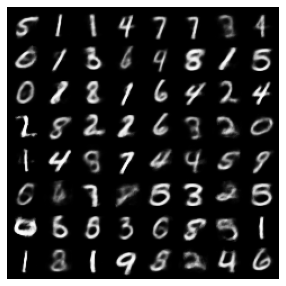

EPOCH: 9.000	train_loss: 1889.174	train_kld: 592.125	train_recon: 1297.048	train_log_var: -0.369	train_mean: 0.000	val_loss: 1876.163	val_kld: 590.639	val_recon: 1285.525	val_log_var: -0.364	val_mean: -0.004	(128.01s - 14.22s remaining)


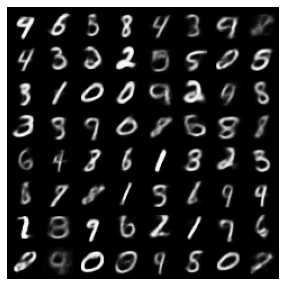

EPOCH: 10.000	train_loss: 1872.416	train_kld: 605.445	train_recon: 1266.971	train_log_var: -0.377	train_mean: 0.000	val_loss: 1861.640	val_kld: 602.491	val_recon: 1259.150	val_log_var: -0.376	val_mean: 0.001	(142.25s - 0.00s remaining)


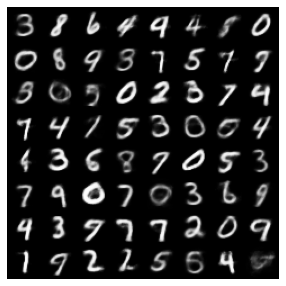

In [ ]:
n_epochs = 10
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(valid_loader)
    for batch_idx, (data, _) in enumerate(valid_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64, 50).to(device)
        sample = vae.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)

In [ ]:
def conv(in_channels, out_channels):
    return torch.nn.Sequential(
        torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
        torch.nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )

In [ ]:
class DCVAE(nn.Module):
    def __init__(self,x_dim, h_dim1, h_dim2, z_dim):
        super(DCVAE, self).__init__()
        self.cnn1=torch.nn.Conv2d(1,32,3,stride=2,padding=1)
        self.cnn2=torch.nn.Conv2d(32,64,3,stride=2,padding=1)
        self.cnnt1=torch.nn.ConvTranspose2d(64,32,2,stride=2)
        self.cnnt2=torch.nn.ConvTranspose2d(32,32,3,stride=2,padding=1,dilation=1)
        self.cnnt3=torch.nn.ConvTranspose2d(32,1,2,stride=2)
        self.max1=torch.nn.MaxPool2d(2,stride=2)
        self.relu=torch.nn.ReLU(inplace=True)
        self.d1 = nn.Linear(x_dim, h_dim1)
        self.d2 = nn.Linear(h_dim1, h_dim2)
        self.d31 = nn.Linear(h_dim2, z_dim)
        self.d32 = nn.Linear(h_dim2, z_dim)
        self.d4 = nn.Linear(z_dim, h_dim2)
        self.d5 = nn.Linear(h_dim2, h_dim1)
        self.d6 = nn.Linear(h_dim1, x_dim)
        self.batch1=torch.nn.BatchNorm2d(32)
        self.batch2=torch.nn.BatchNorm2d(64)
    def encoder(self, x):
        x=self.cnn1(x)
        #x=self.max1(x)
        x=self.cnn2(x)
        x=self.batch2(x)
        x=self.relu(x)
        #x=self.max1(x)
        x=torch.nn.Flatten()(x)
        h = F.relu(self.d1(x))
        h = F.relu(self.d2(h))
        return self.d31(h), self.d32(h)
    def sampling(self, mean, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)
    def decoder(self, z):
        h = F.relu(self.d4(z))
        h = F.relu(self.d5(h))
        h = F.relu(self.d6(h))
        h=h.view(-1,64,7,7)
        up_conv=self.cnnt1(h)
        rl=self.relu(up_conv)
        #up_conv2=self.cnnt2(rl)
        #rl1=self.relu(up_conv2)
        up_conv3=self.cnnt3(rl)
        return F.sigmoid(up_conv3)
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.sampling(mean, log_var)
        return self.decoder(z), mean, log_var


In [ ]:
model=DCVAE(x_dim=64*7*7,h_dim1=512, h_dim2=256, z_dim=50).to("cuda")
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [ ]:
summary(model,torch.zeros((2,1,28,28)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 14, 14]          320
├─Conv2d: 1-2                            [-1, 64, 7, 7]            18,496
├─BatchNorm2d: 1-3                       [-1, 64, 7, 7]            128
├─ReLU: 1-4                              [-1, 64, 7, 7]            --
├─Linear: 1-5                            [-1, 512]                 1,606,144
├─Linear: 1-6                            [-1, 256]                 131,328
├─Linear: 1-7                            [-1, 50]                  12,850
├─Linear: 1-8                            [-1, 50]                  12,850
├─Linear: 1-9                            [-1, 256]                 13,056
├─Linear: 1-10                           [-1, 512]                 131,584
├─Linear: 1-11                           [-1, 3136]                1,608,768
├─ConvTranspose2d: 1-12                  [-1, 32, 14, 14]          8,224
├─ReLU: 1-13                            

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 14, 14]          320
├─Conv2d: 1-2                            [-1, 64, 7, 7]            18,496
├─BatchNorm2d: 1-3                       [-1, 64, 7, 7]            128
├─ReLU: 1-4                              [-1, 64, 7, 7]            --
├─Linear: 1-5                            [-1, 512]                 1,606,144
├─Linear: 1-6                            [-1, 256]                 131,328
├─Linear: 1-7                            [-1, 50]                  12,850
├─Linear: 1-8                            [-1, 50]                  12,850
├─Linear: 1-9                            [-1, 256]                 13,056
├─Linear: 1-10                           [-1, 512]                 131,584
├─Linear: 1-11                           [-1, 3136]                1,608,768
├─ConvTranspose2d: 1-12                  [-1, 32, 14, 14]          8,224
├─ReLU: 1-13                            

In [ ]:
def train_batch(data, model, optimizer, loss_function):
    model.train()
    data = data.to("cuda")
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data, model, loss_function):
    model.eval()
    data = data.to("cuda")
    recon, mean, log_var = model(data)
    loss, mse, kld = loss_function(recon, data, mean, log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [ ]:
def loss_function(recon_x, x, mean, log_var):
    loss_recon=F.mse_loss(recon_x,x,reduce="mean")
    kld=-0.5*torch.mean(1+log_var*(mean.pow(2))-log_var.exp())
    loss=loss_recon+kld
    return loss,kld,loss_recon

In [ ]:
train_loader=DataLoader(train_data,batch_size=64,shuffle=True)
valid_loader=DataLoader(test_data,batch_size=64,shuffle=False)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


EPOCH: 1.000	train_loss: 707995768138917478400.000	train_kld: 0.074	train_recon: 707995768138917478400.000	train_log_var: -1696074112.000	train_mean: 125874.938	val_loss: 269034363282184470528.000	val_kld: 0.074	val_recon: 269034363282184470528.000	val_log_var: -1372205952.000	val_mean: 103596.586	(20.76s - 2055.65s remaining)


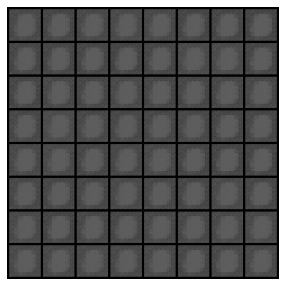

EPOCH: 2.000	train_loss: 192450106260981809152.000	train_kld: 0.073	train_recon: 192450106260981809152.000	train_log_var: -1227909888.000	train_mean: 93806.547	val_loss: 132092301105009000448.000	val_kld: 0.074	val_recon: 132092301105009000448.000	val_log_var: -1093767680.000	val_mean: 84634.508	(41.65s - 2040.88s remaining)


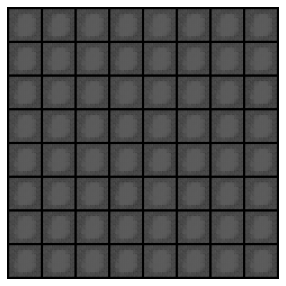

EPOCH: 3.000	train_loss: 40033288736068337664.000	train_kld: 0.071	train_recon: 40033288736068337664.000	train_log_var: -1018856896.000	train_mean: 30110.113	val_loss: 865970547673006080.000	val_kld: 0.066	val_recon: 865970547673006080.000	val_log_var: -990992576.000	val_mean: 549.527	(62.55s - 2022.55s remaining)


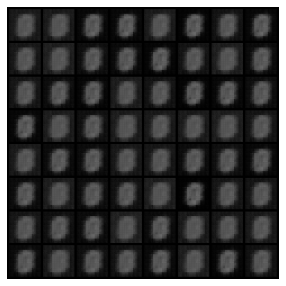

EPOCH: 4.000	train_loss: 149046119366656.000	train_kld: 0.064	train_recon: 149046119366656.000	train_log_var: -969626624.000	train_mean: -1.818	val_loss: 117167404089344.000	val_kld: 0.063	val_recon: 117167404089344.000	val_log_var: -953131456.000	val_mean: 2.028	(83.99s - 2015.67s remaining)


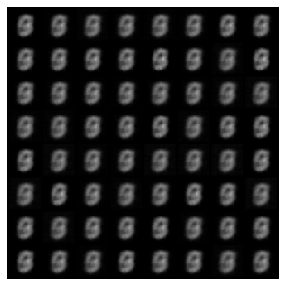

EPOCH: 5.000	train_loss: 89139881967616.000	train_kld: 0.062	train_recon: 89139881967616.000	train_log_var: -934086464.000	train_mean: -1.198	val_loss: 70051705126912.000	val_kld: 0.062	val_recon: 70051705126912.000	val_log_var: -919047616.000	val_mean: 3.953	(105.08s - 1996.48s remaining)


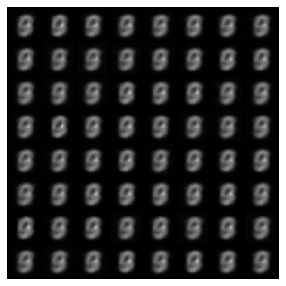

EPOCH: 6.000	train_loss: 48440218222592.000	train_kld: 0.062	train_recon: 48440218222592.000	train_log_var: -899922240.000	train_mean: -0.725	val_loss: 35224662573056.000	val_kld: 0.063	val_recon: 35224662573056.000	val_log_var: -884937856.000	val_mean: 3.085	(126.39s - 1980.18s remaining)


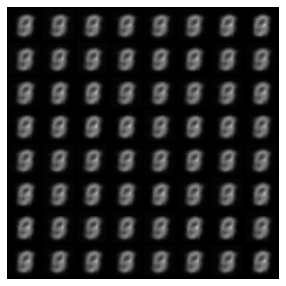

EPOCH: 7.000	train_loss: 25479790723072.000	train_kld: 0.063	train_recon: 25479790723072.000	train_log_var: -867047552.000	train_mean: -0.390	val_loss: 19082378215424.000	val_kld: 0.064	val_recon: 19082378215424.000	val_log_var: -852737344.000	val_mean: 3.722	(147.44s - 1958.88s remaining)


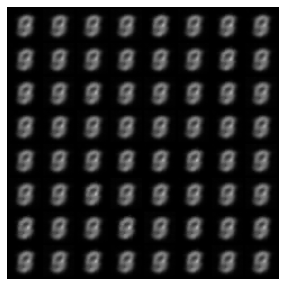

EPOCH: 8.000	train_loss: 15064816943104.000	train_kld: 0.064	train_recon: 15064816943104.000	train_log_var: -835366016.000	train_mean: -0.246	val_loss: 13405016555520.000	val_kld: 0.065	val_recon: 13405016555520.000	val_log_var: -821439360.000	val_mean: 4.703	(168.56s - 1938.39s remaining)


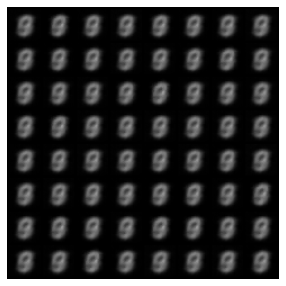

EPOCH: 9.000	train_loss: 11291043299328.000	train_kld: 0.065	train_recon: 11291043299328.000	train_log_var: -804777600.000	train_mean: -0.166	val_loss: 11161835667456.000	val_kld: 0.066	val_recon: 11161835667456.000	val_log_var: -791446016.000	val_mean: 4.616	(189.75s - 1918.54s remaining)


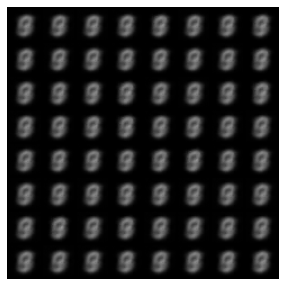

EPOCH: 10.000	train_loss: 9647203287040.000	train_kld: 0.066	train_recon: 9647203287040.000	train_log_var: -775211968.000	train_mean: -0.151	val_loss: 10001857904640.000	val_kld: 0.066	val_recon: 10001857904640.000	val_log_var: -762189696.000	val_mean: 5.390	(211.30s - 1901.66s remaining)


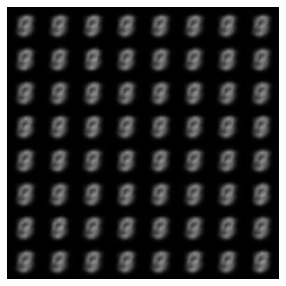

EPOCH: 11.000	train_loss: 8494895857664.000	train_kld: 0.066	train_recon: 8494895857664.000	train_log_var: -746656256.000	train_mean: -0.119	val_loss: 8227797860352.000	val_kld: 0.066	val_recon: 8227797860352.000	val_log_var: -734087808.000	val_mean: 2.273	(233.05s - 1885.58s remaining)


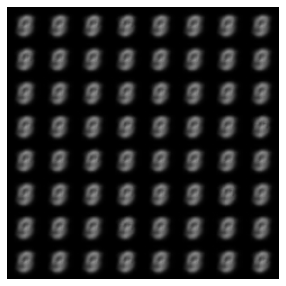

EPOCH: 12.000	train_loss: 7466101243904.000	train_kld: 0.066	train_recon: 7466101243904.000	train_log_var: -719130816.000	train_mean: -0.128	val_loss: 7388537028608.000	val_kld: 0.066	val_recon: 7388537028608.000	val_log_var: -706979520.000	val_mean: 3.488	(254.42s - 1865.72s remaining)


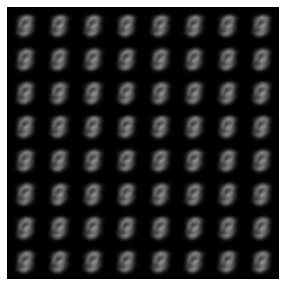

EPOCH: 13.000	train_loss: 6530339438592.000	train_kld: 0.066	train_recon: 6530339438592.000	train_log_var: -692620608.000	train_mean: -0.117	val_loss: 6367005376512.000	val_kld: 0.066	val_recon: 6367005376512.000	val_log_var: -681120448.000	val_mean: 3.385	(275.75s - 1845.42s remaining)


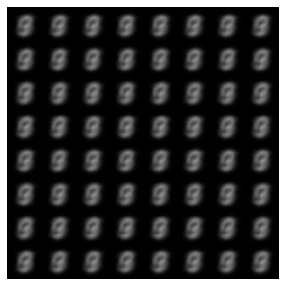

EPOCH: 14.000	train_loss: 5654375301120.000	train_kld: 0.066	train_recon: 5654375301120.000	train_log_var: -667082688.000	train_mean: -0.108	val_loss: 5506160656384.000	val_kld: 0.066	val_recon: 5506160656384.000	val_log_var: -655779968.000	val_mean: 2.526	(296.95s - 1824.12s remaining)


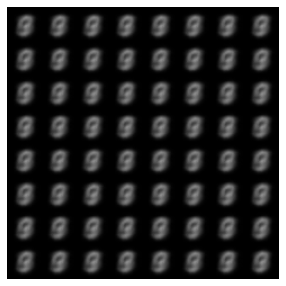

EPOCH: 15.000	train_loss: 4847859400704.000	train_kld: 0.066	train_recon: 4847859400704.000	train_log_var: -642487744.000	train_mean: -0.105	val_loss: 5399925227520.000	val_kld: 0.066	val_recon: 5399925227520.000	val_log_var: -631743168.000	val_mean: 6.050	(318.25s - 1803.40s remaining)


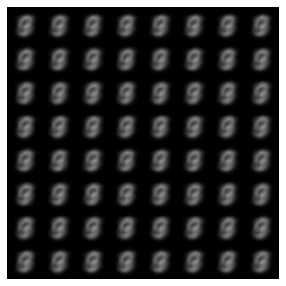

EPOCH: 16.000	train_loss: 4118920036352.000	train_kld: 0.066	train_recon: 4118920036352.000	train_log_var: -618814656.000	train_mean: -0.094	val_loss: 4731831320576.000	val_kld: 0.066	val_recon: 4731831320576.000	val_log_var: -608508864.000	val_mean: 6.795	(339.50s - 1782.39s remaining)


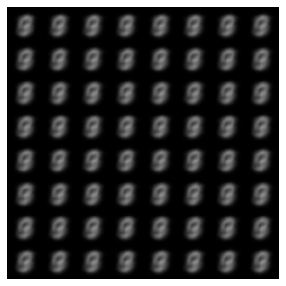

EPOCH: 17.000	train_loss: 3499718082560.000	train_kld: 0.066	train_recon: 3499718082560.000	train_log_var: -596027520.000	train_mean: -0.077	val_loss: 3562208231424.000	val_kld: 0.066	val_recon: 3562208231424.000	val_log_var: -586284416.000	val_mean: 4.897	(360.71s - 1761.11s remaining)


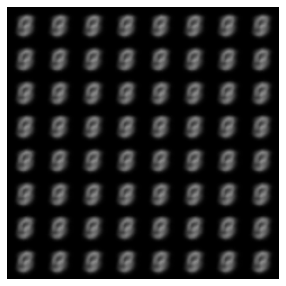

EPOCH: 18.000	train_loss: 2859846598656.000	train_kld: 0.066	train_recon: 2859846598656.000	train_log_var: -574113664.000	train_mean: -0.075	val_loss: 3108228562944.000	val_kld: 0.066	val_recon: 3108228562944.000	val_log_var: -564614528.000	val_mean: 6.606	(381.99s - 1740.19s remaining)


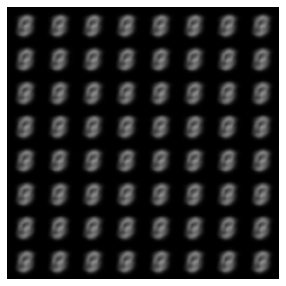

EPOCH: 19.000	train_loss: 2359229415424.000	train_kld: 0.066	train_recon: 2359229415424.000	train_log_var: -553050304.000	train_mean: -0.058	val_loss: 1927256080384.000	val_kld: 0.066	val_recon: 1927256080384.000	val_log_var: -543819712.000	val_mean: -5.308	(403.28s - 1719.25s remaining)


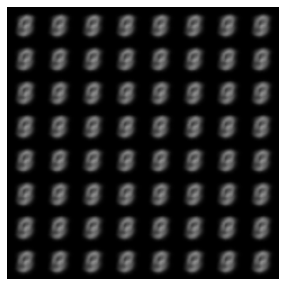

EPOCH: 20.000	train_loss: 1857197572096.000	train_kld: 0.066	train_recon: 1857197572096.000	train_log_var: -532819008.000	train_mean: -0.056	val_loss: 1365698543616.000	val_kld: 0.067	val_recon: 1365698543616.000	val_log_var: -523899488.000	val_mean: -0.286	(424.93s - 1699.74s remaining)


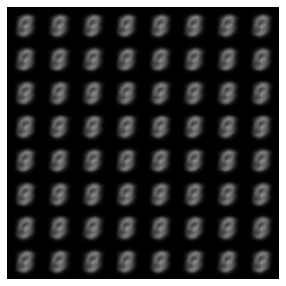

EPOCH: 21.000	train_loss: 1414738477056.000	train_kld: 0.066	train_recon: 1414738477056.000	train_log_var: -513398048.000	train_mean: -0.040	val_loss: 1248536559616.000	val_kld: 0.067	val_recon: 1248536559616.000	val_log_var: -504840832.000	val_mean: 3.721	(446.32s - 1679.00s remaining)


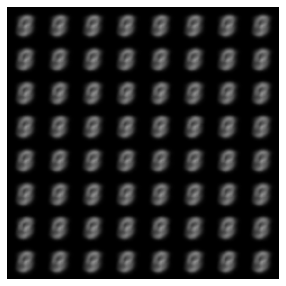

EPOCH: 21.469	train_loss: 1315121135616.000	train_kld: 0.066	train_recon: 1315121135616.000	train_log_var: -495224256.000	train_mean: 7.071	(455.51s - 1666.18s remaining)

KeyboardInterrupt: ignored

In [ ]:
n_epochs = 100
log = Report(n_epochs)

for epoch in range(n_epochs):
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, model, optimizer, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, train_loss=loss, train_kld=kld, train_recon=recon, train_log_var=log_var, train_mean=mean, end='\r')
        
    N = len(valid_loader)
    for batch_idx, (data, _) in enumerate(valid_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, model, loss_function)
        pos = epoch + (1+batch_idx)/N
        log.record(pos, val_loss=loss, val_kld=kld, val_recon=recon, val_log_var=log_var, val_mean=mean, end='\r')
        
    log.report_avgs(epoch+1)
    with torch.no_grad():
        z = torch.randn(64,50).to(device)
        sample = model.decoder(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1,2,0)
        show(images)